# Boilerplate

Packae installation, loading, and dataloaders. There's also a simple model defined. You can change it your favourite architecture if you want.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time

from torchvision import datasets, transforms
from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN. You can change this if you want.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,40)
        self.fc3 = nn.Linear(40,10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image

# Implement the Attacks

Functions are given a simple useful signature that you can start with. Feel free to extend the signature as you see fit.

You may find it useful to create a 'batched' version of PGD that you can use to create the adversarial attack.

In [2]:
def fgsm(model, x, eps, eps_step, targeted=False, target=-1):
    dataset = []
    
    if targeted:
        for batch_idx, (x_batch, y_batch) in enumerate(x):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            adv_x = x_batch.clone().detach()
            adv_x.requires_grad_()
            loss = torch.nn.CrossEntropyLoss()(model(adv_x), torch.tensor([target]*adv_x.shape[0], dtype=torch.long))
            loss.backward()
            with torch.no_grad():
                adv_x -= eps_step * torch.sign(adv_x.grad)
                adv_x = torch.clamp(adv_x, x_batch - eps, x_batch + eps)
                adv_x = torch.clamp(adv_x, 0, 1)
            
            for i in range(adv_x.shape[0]):
                dataset.append((adv_x[i], y_batch[i]))
    else:
        for batch_idx, (x_batch, y_batch) in enumerate(x):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            adv_x = x_batch.clone().detach()
            adv_x.requires_grad_()
            loss = torch.nn.CrossEntropyLoss()(model(adv_x), y_batch)
            loss.backward()
            with torch.no_grad():
                adv_x += eps_step * torch.sign(adv_x.grad)
                adv_x = torch.clamp(adv_x, x_batch - eps, x_batch + eps)
                adv_x = torch.clamp(adv_x, 0, 1)
            
            for i in range(adv_x.shape[0]):
                dataset.append((adv_x[i], y_batch[i]))
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)


def pgd_untargeted(model, x, eps, eps_step, k):
    dataset = []
    for batch_idx, (x_batch, y_batch) in enumerate(x):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        adv_x = x_batch.clone().detach()
        adv_x.requires_grad_()
        for _ in range(k):
            loss = torch.nn.CrossEntropyLoss()(model(adv_x), y_batch)
            loss.backward()
            with torch.no_grad():
                adv_x += eps_step * torch.sign(adv_x.grad)
                adv_x += torch.clamp(adv_x, x_batch - eps, x_batch + eps) - adv_x
                adv_x += torch.clamp(adv_x, 0, 1) - adv_x
            adv_x.grad.zero_()

        for i in range(adv_x.shape[0]):
            dataset.append((adv_x[i], y_batch[i]))
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Implement Adversarial Training

In [3]:
def train_model(model, num_epochs, enable_defense=True):
    learning_rate = 0.0001

    opt = optim.Adam(params=model.parameters(), lr=learning_rate)

    ce_loss = torch.nn.CrossEntropyLoss()

    tot_steps = 0

    for epoch in range(1,num_epochs+1):
        t1 = time.time()
        
        
        if enable_defense:
            pgd_loader_list = list(pgd_untargeted(model, train_loader, 0.05, 0.01, 6))

        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            if enable_defense:
                (adv_x, adv_y) = pgd_loader_list[batch_idx]
                x_batch = torch.cat((x_batch, adv_x.detach()), 0)
                y_batch = torch.cat((y_batch, adv_y.detach()), 0)
               
            tot_steps += 1
            opt.zero_grad()
            out = model(x_batch)
            batch_loss = ce_loss(out, y_batch)
            batch_loss.backward()
            opt.step()

        tot_test, tot_acc = 0.0, 0.0
        for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            out = model(x_batch)
            pred = torch.max(out, dim=1)[1]
            acc = pred.eq(y_batch).sum().item()
            tot_acc += acc
            tot_test += x_batch.size()[0]
        t2 = time.time()

        print('Epoch %d: Accuracy %.5lf [%.2lf seconds]' % (epoch, tot_acc/tot_test, t2-t1))

# Study Accuracy, Quality, etc.

Compare the various results and report your observations on the submission.

In [4]:
def get_accuracy(model, data):
    tot_test, tot_acc = 0.0, 0.0
    for batch_idx, (x_batch, y_batch) in enumerate(data):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        out = model(x_batch)
        pred = torch.max(out, dim=1)[1]
        acc = pred.eq(y_batch).sum().item()
        tot_acc += acc
        tot_test += x_batch.size()[0]
    return tot_acc/tot_test

## Training with no defense

In [5]:
model = nn.Sequential(Normalize(), Net())
model = model.to(device)
model.train()
train_model(model, 20, False)

Epoch 1: Accuracy 0.91850 [8.67 seconds]
Epoch 2: Accuracy 0.93520 [8.60 seconds]
Epoch 3: Accuracy 0.94570 [8.69 seconds]
Epoch 4: Accuracy 0.95360 [9.45 seconds]
Epoch 5: Accuracy 0.95680 [10.39 seconds]
Epoch 6: Accuracy 0.96030 [9.89 seconds]
Epoch 7: Accuracy 0.96520 [9.98 seconds]
Epoch 8: Accuracy 0.96680 [10.09 seconds]
Epoch 9: Accuracy 0.97030 [9.70 seconds]
Epoch 10: Accuracy 0.96900 [9.61 seconds]
Epoch 11: Accuracy 0.97270 [9.13 seconds]
Epoch 12: Accuracy 0.97330 [9.23 seconds]
Epoch 13: Accuracy 0.97490 [9.29 seconds]
Epoch 14: Accuracy 0.97310 [9.30 seconds]
Epoch 15: Accuracy 0.97500 [9.30 seconds]
Epoch 16: Accuracy 0.97530 [9.30 seconds]
Epoch 17: Accuracy 0.97540 [9.46 seconds]
Epoch 18: Accuracy 0.97570 [9.40 seconds]
Epoch 19: Accuracy 0.97760 [9.35 seconds]
Epoch 20: Accuracy 0.97770 [9.30 seconds]


In [6]:
test_acc = get_accuracy(model, test_loader)
print("Accuracy on test set =", test_acc)
fgsm_untarget_acc = get_accuracy(model, fgsm(model, test_loader, 0.1, 0.04))
print("Accuracy on test set perturbed with FGSM =", fgsm_untarget_acc)
pgd_untarget_acc = get_accuracy(model, pgd_untargeted(model, test_loader, 0.05, 0.01, 6))
print("Accuracy on test set perturbed with PGD =", pgd_untarget_acc)

Accuracy on test set = 0.9777
Accuracy on test set perturbed with FGSM = 0.7858
Accuracy on test set perturbed with PGD = 0.6229


## Robust training

In [7]:
robust_model = nn.Sequential(Normalize(), Net())
robust_model = robust_model.to(device)
robust_model.train()
train_model(robust_model, 20, True)

Epoch 1: Accuracy 0.92350 [24.99 seconds]
Epoch 2: Accuracy 0.94250 [25.45 seconds]
Epoch 3: Accuracy 0.95620 [25.77 seconds]
Epoch 4: Accuracy 0.96340 [27.23 seconds]
Epoch 5: Accuracy 0.96730 [34.21 seconds]
Epoch 6: Accuracy 0.97080 [29.08 seconds]
Epoch 7: Accuracy 0.97060 [27.99 seconds]
Epoch 8: Accuracy 0.97430 [29.33 seconds]
Epoch 9: Accuracy 0.97440 [28.98 seconds]
Epoch 10: Accuracy 0.97850 [28.66 seconds]
Epoch 11: Accuracy 0.97720 [29.07 seconds]
Epoch 12: Accuracy 0.97890 [27.57 seconds]
Epoch 13: Accuracy 0.97900 [26.20 seconds]
Epoch 14: Accuracy 0.98080 [28.48 seconds]
Epoch 15: Accuracy 0.97910 [26.62 seconds]
Epoch 16: Accuracy 0.97990 [26.09 seconds]
Epoch 17: Accuracy 0.98110 [25.79 seconds]
Epoch 18: Accuracy 0.98210 [29.06 seconds]
Epoch 19: Accuracy 0.98210 [26.01 seconds]
Epoch 20: Accuracy 0.98160 [26.24 seconds]


In [8]:
test_acc = get_accuracy(robust_model, test_loader)
print("Accuracy on test set =", test_acc)
fgsm_untarget_acc = get_accuracy(robust_model, fgsm(robust_model, test_loader, 0.1, 0.04))
print("Accuracy on test set perturbed with FGSM =", fgsm_untarget_acc)
pgd_untarget_acc = get_accuracy(robust_model, pgd_untargeted(robust_model, test_loader, 0.05, 0.01, 6))
print("Accuracy on test set perturbed with PGD =", pgd_untarget_acc)

Accuracy on test set = 0.9816
Accuracy on test set perturbed with FGSM = 0.8218
Accuracy on test set perturbed with PGD = 0.6884


## Adversarial image quality (PGD attack)

In [9]:
import matplotlib.pyplot as plt
def show(model, img, label):
    plt.imshow(img.detach().numpy().reshape(28,28), cmap="gray")
    plt.show()
    print("Dataset image prediction =", torch.max(model(img), dim=1)[1][0])
    
    _adv_img = pgd_untargeted(model, [(img[None,:,:,:], torch.tensor([label], dtype=torch.long))], 0.05, 0.01, 6)
    adv_img = list(_adv_img)[0][0][0]
    plt.imshow(adv_img.detach().numpy().reshape(28,28), cmap="gray")
    plt.show()
    print("Adversarial image prediction =", torch.max(model(adv_img), dim=1)[1][0])

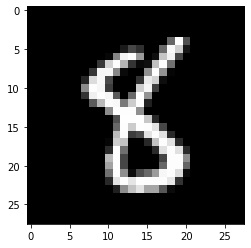

Dataset image prediction = tensor(8)


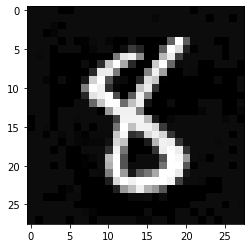

Adversarial image prediction = tensor(6)


In [12]:
show(model, *test_dataset[344]) # try any number in range(10000)

### Robust model is safe from PGD attack for this image but the base model is not robust

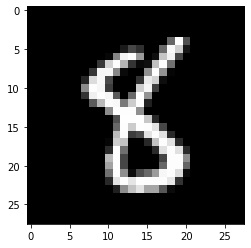

Dataset image prediction = tensor(8)


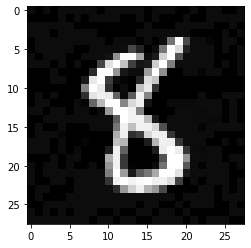

Adversarial image prediction = tensor(8)


In [11]:
show(robust_model, *test_dataset[344])

### Carlini and Wagner attack gives a lower accuracy rate on the robust model

In [67]:
def carlini_wagner(model, x, eps, eps_step, k):
    dataset = []
    for batch_idx, (x_batch, y_batch) in enumerate(x):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        adv_x = x_batch.clone().detach()
        adv_x.requires_grad_()
        for _ in range(k):
            loss = torch.nn.CrossEntropyLoss()(model(adv_x), y_batch) - \
                                                torch.norm(x_batch-adv_x, p=float('inf'))
            loss.backward()
            with torch.no_grad():
                adv_x += eps_step * torch.sign(adv_x.grad)
                adv_x += torch.clamp(adv_x, x_batch - eps, x_batch + eps) - adv_x
                adv_x += torch.clamp(adv_x, 0, 1) - adv_x
            adv_x.grad.zero_()

        for i in range(adv_x.shape[0]):
            dataset.append((adv_x[i], y_batch[i]))
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [72]:
cw_acc = get_accuracy(robust_model, carlini_wagner(robust_model, test_loader, 0.05, 0.001, 100))
print("Accuracy on test set perturbed with CW attack =", cw_acc)

Accuracy on test set perturbed with CW attack = 0.6754
